<a href="https://colab.research.google.com/github/Marcusleeleelee/FTEC4998-4999/blob/main/FTEC4998_4999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
from tqdm import tqdm
import inspect
import matplotlib.pyplot as plt
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 1: Utils - ok
def uni_list(input): return list(set(input))

In [3]:
class Dataset():
    def __init__(self, file_path):
        self.dataset = pd.read_feather(file_path)
        self.original = self.dataset.copy()
        self.X_train, self.y_train = None, None
        self.X_test, self.y_test = None, None
        self.label = 'loan_condition_cat'
        self.min_max_columns = ['annual_inc', 'year']
        self.means = {}
        self.stds = {}
        self.mins = {}
        self.maxs = {}

    def show(self, rows=10):
        return self.dataset.head(rows)

    def basic_processing(self):
        temp_func_2 = lambda x: {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G': 7}[str(x)]
        columns_to_delete = [
            'id', 'issue_d', 'home_ownership_cat', 'income_category', 'income_cat', 'term_cat', 'application_type_cat',
            'purpose_cat', 'interest_payment_cat', 'loan_condition'
        ]
        self.dataset.drop(columns=columns_to_delete, inplace=True)
        self.dataset['grade'] = self.dataset['grade'].apply(temp_func_2)
        self.dataset['final_d'] = self.dataset['final_d'].apply(lambda x: str(x)[-4:]).apply(int)
        self.dataset['year'] = self.dataset['year'].apply(lambda x: str(x)[-4:]).apply(int)
        self.dataset = pd.get_dummies(self.dataset, columns=['home_ownership', 'term', 'application_type',
                                                             'purpose', 'interest_payments', 'region'], dtype=int)


    def train_test_split(self, test_size=0.2, random_state=42):
        X = self.dataset.drop(columns=[self.label])
        y = self.dataset[self.label]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        self.original_columns = X.columns

        # Sort by index
        self.X_train.sort_index(inplace=True)
        self.X_train.reset_index(drop=True, inplace=True)
        self.X_test.sort_index(inplace=True)
        self.X_test.reset_index(drop=True, inplace=True)
        self.y_train.sort_index(inplace=True)
        self.y_train.reset_index(drop=True, inplace=True)
        self.y_test.sort_index(inplace=True)
        self.y_test.reset_index(drop=True, inplace=True)

    def preprocessing_train(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_train.columns if col not in columns_to_normalize]

        # Z-score normalization
        for col in columns_to_scale:
            mean = np.mean(self.X_train[col])
            std = np.std(self.X_train[col])
            self.means[col] = mean
            self.stds[col] = std
            self.X_train[col] = (self.X_train[col] - mean) / std

        # Min-Max normalization
        for col in columns_to_normalize:
            min_val = np.min(self.X_train[col])
            max_val = np.max(self.X_train[col])
            self.mins[col] = min_val
            self.maxs[col] = max_val
            self.X_train[col] = (self.X_train[col] - min_val) / (max_val - min_val)

        # Perform PCA
        selected_columns = self.perform_pca(self.X_train, n_components=35)
        self.X_train = self.X_train[selected_columns]


    def perform_pca(self, data, n_components):
        # Center the data
        data_mean = np.mean(data, axis=0)
        centered_data = data - data_mean

        # Compute covariance matrix
        cov_matrix = np.cov(centered_data, rowvar=False)

        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Select the top n_components
        selected_eigenvectors = sorted_eigenvectors[:, :n_components]

        # Identify important features
        feature_importance = np.abs(selected_eigenvectors).sum(axis=1)
        important_indices = np.argsort(feature_importance)[::-1][:n_components]

        # Return the original column names of these features
        important_features = [self.original_columns[i] for i in important_indices]

        return important_features

    def preprocessing_test(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_test.columns if col not in columns_to_normalize]

        # Apply Z-score normalization using training statistics
        for col in columns_to_scale:
            self.X_test[col] = (self.X_test[col] - self.means[col]) / self.stds[col]

        # Apply Min-Max normalization using training statistics
        for col in columns_to_normalize:
            self.X_test[col] = (self.X_test[col] - self.mins[col]) / (self.maxs[col] - self.mins[col])

        # Apply PCA using training components
        self.X_test = self.X_test[[i for i in self.X_train.columns.to_list()]]

In [4]:
# Calculating # ok
data = Dataset('/content/drive/My Drive/Colab Notebooks/FTEC4998_9/loan_final313_processed.feather')
data.basic_processing()
data.train_test_split()
data.preprocessing_train()
data.preprocessing_test()

In [5]:
# Data conversion # ok
train_x, train_y = data.X_train, data.y_train
test_x, test_y = data.X_test, data.y_test
counts = np.mean(train_y == 1) * 100
print(counts)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
# Ensure y_train is binary
assert set(train_y).issubset({0, 1}), "Target values must be 0 or 1 for binary classification."
# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

7.5910370853482805
(709903, 35) (709903,)
(177476, 35) (177476,)


In [6]:
# Train, predict, and accuracy functions
def train_model_pt(model): # ok
    model.train()
    for epoch in range(model.epochs):
        model.optimizer.zero_grad()
        outputs = model(model.train_x)
        loss = model.criterion(outputs, model.train_y)
        loss.backward()
        model.optimizer.step()
        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

def predict_model_pt(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(next(model.parameters()).device)
        outputs = model(X).squeeze()
        return (outputs > 0.5).float().cpu().numpy()  # Convert to numpy array
def calculate_accuracy_pt(model, X, y, pred=None):
    # Ensure X and y are on the correct device
    X = X.to(next(model.parameters()).device)
    y = y.to(next(model.parameters()).device)

    # Get predictions
    predictions = predict_model_pt(model, X) if pred is None else pred

    # Ensure predictions and labels are tensors and the same shape
    predictions = predictions.squeeze()
    y = y.squeeze()

    # Convert to tensors if necessary
    if not isinstance(predictions, torch.Tensor):
        predictions = torch.tensor(predictions)
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y)

    # Calculate accuracy
    correct = (predictions == y).sum().item()
    accuracy = correct / len(y)
    return accuracy

def df_to_tensor(x, y):
    assert isinstance(x, pd.DataFrame) and isinstance(y, pd.Series)
    return torch.tensor(x.to_numpy(), dtype=torch.float32).to(device), torch.tensor(y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
test_x, test_y = data.X_test, data.y_test
test_x_tensor, test_y_tensor = df_to_tensor(data.X_test, data.y_test)

In [11]:
# MLP model
class ANN(nn.Module): # Not yet finish the plot function
    def __init__(self, train_x, train_y, lr=0.001):
        super(ANN, self).__init__()
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)
        self.input_dim = self.train_x.shape[1]
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self._initialize_weights()
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.epochs = 50

    def forward(self, x):
        return self.net(x)
    def _initialize_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# Logistic Regression as a neural network
class LogisticRegressionModel(nn.Module): # Not yet finish the plot function
    def __init__(self, train_x, train_y, lr=0.001):
        super(LogisticRegressionModel, self).__init__()
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)
        self.input_dim = self.train_x.shape[1]
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 1),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.epochs = 1200

    def forward(self, x):
        return self.net(x)

# SVM
class SVMClassifier():
    def __init__(self, train_x, train_y, fraction=0.1):
        # Sample a fraction of the data
        self.train_x = train_x
        self.train_y = train_y
        self.model = None
        self.accuracies = []

    def fit(self):
        # Use Bagging with SVM
        self.model = BaggingClassifier(
            estimator=SVC(C=0.1, kernel='poly', degree=3, gamma='scale'),
            n_estimators=6,
            random_state=42,
            max_samples=0.001
        )
        self.model.fit(self.train_x, self.train_y)
        predictions = self.model.predict(self.train_x)
        accuracy = accuracy_score(self.train_y, predictions)
        self.accuracies.append(accuracy)

    def predict(self, X):
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        predictions = self.model.predict(X).astype(float) if pred is None else pred
        accuracy = accuracy_score(y, predictions)
        return accuracy

    def plot_training_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o', linestyle='-')
        plt.title('SVM Training Accuracy Curve')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.show()
# NB
class NaiveBayesClassifier():
    def __init__(self, train_x, train_y, priors=None, var_smoothing=1e-9):
        self.model = GaussianNB(priors=priors, var_smoothing=var_smoothing)
        self.train_x = train_x
        self.train_y = train_y
        self.accuracies = []

    def fit(self):
        self.model.fit(self.train_x, self.train_y)
        predictions = self.model.predict(self.train_x)
        accuracy = accuracy_score(self.train_y, predictions)
        self.accuracies.append(accuracy)

    def predict(self, X):
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        predictions = self.model.predict(X).astype(float) if pred is None else pred
        accuracy = accuracy_score(y, predictions)
        return accuracy

    def plot_training_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o', linestyle='-')
        plt.title('Naive Bayes Training Accuracy Curve')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.show()

# RF
class RandomForestModel():
    def __init__(self, train_x, train_y, n_estimators=10, max_depth=None, random_state=42):
        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, max_samples=0.05, warm_start=True)
        self.train_x = train_x
        self.train_y = train_y
        self.prediction = None
        self.accuracies = []

    def fit(self):
        for i in range(1, self.model.n_estimators + 1):
            self.model.n_estimators = i
            self.model.fit(self.train_x, self.train_y)
            predictions = self.model.predict(self.train_x)
            accuracy = accuracy_score(self.train_y, predictions)
            self.accuracies.append(accuracy)

    def predict(self, X):
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        predictions = self.model.predict(X).astype(float) if pred is None else pred
        accuracy = accuracy_score(y, predictions)
        return accuracy

    def plot_training_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o', linestyle='-')
        plt.title('Random Forest Training Accuracy Curve')
        plt.xlabel('Number of Trees')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.show()
#XBG
class XGBoostClassifier():
    def __init__(self, train_x, train_y, n_estimators=100,
                 learning_rate=0.1, max_depth=6, subsample=0.8,
                 colsample_bytree=0.8, gamma=0, reg_alpha=0, reg_lambda=1):
        self.model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            eval_metric='error'  # Error metric for accuracy
        )
        self.train_x = train_x
        self.train_y = train_y

    def fit(self):
        self.model.fit(
            self.train_x, self.train_y,
            eval_set=[(self.train_x, self.train_y)],
            verbose=False
        )

    def predict(self, X):
        return self.model.predict(X).astype(float)

    def calculate_accuracy(self, X, y, pred=None):
        predictions = self.model.predict(X).astype(float) if pred is None else pred
        accuracy = accuracy_score(y, predictions)
        return accuracy

    def plot_training_curve(self):
        evals_result = self.model.evals_result()
        error_values = evals_result['validation_0']['error']
        accuracy_values = [1 - e for e in error_values]  # Convert error to accuracy
        epochs = len(accuracy_values)
        x_axis = range(0, epochs)

        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, accuracy_values, marker='o', linestyle='-')
        plt.title('XGBoost Training Accuracy Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.show()

In [10]:
ann_model = ANN(train_x, train_y)
train_model_pt(ann_model)
acc = predict_model_pt(ann_model, ann_model.train_x)
print(type(acc))
print(np.unique(acc))
print(calculate_accuracy_pt(ann_model, ann_model.train_x, ann_model.train_y, acc))

Epoch 0, Loss: 0.9465360045433044
Epoch 5, Loss: 0.8004679679870605
Epoch 10, Loss: 0.7337527275085449
Epoch 15, Loss: 0.6813313364982605
Epoch 20, Loss: 0.6381024122238159
Epoch 25, Loss: 0.5998936891555786
Epoch 30, Loss: 0.5630395412445068
Epoch 35, Loss: 0.5268213748931885
Epoch 40, Loss: 0.49174249172210693
Epoch 45, Loss: 0.45580756664276123
<class 'numpy.ndarray'>
[0. 1.]
0.9475942487917364


In [12]:
svm = SVMClassifier(train_x, train_y)
svm.fit()
acc = svm.predict(svm.train_x)
print(type(acc))
print(np.unique(acc))
print(svm.calculate_accuracy(svm.train_x, svm.train_y, acc))

<class 'numpy.ndarray'>
[0. 1.]
0.9285846094466427


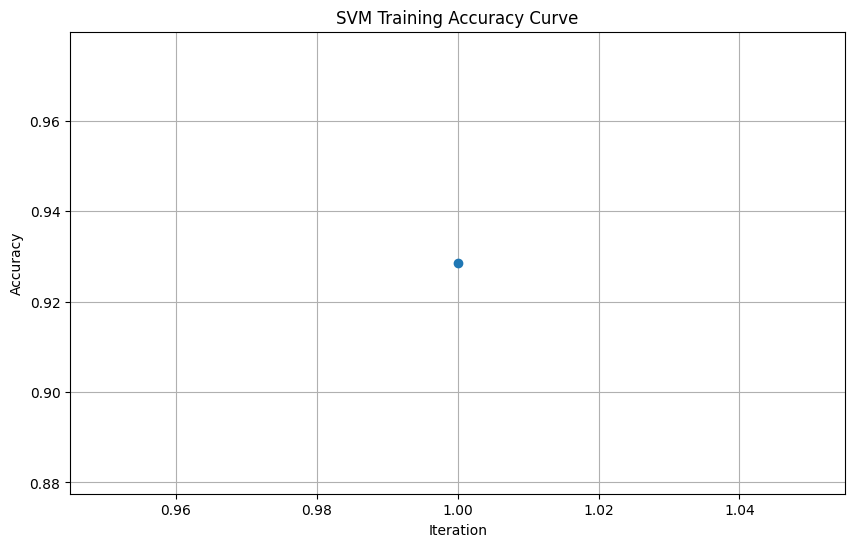

In [13]:
svm.plot_training_curve()

In [ ]:
import numpy as np
import pandas as pd
import inspect

class Adaboost():
    def __init__(self, classes_dict, train_x, train_y):
        self.classes_dict = classes_dict
        self.model_order = list(classes_dict.keys())
        self.train_x = train_x
        self.train_y = train_y
        self.trained_model = {}
        self.training_data_history = {'base': {'X': self.train_x, 'y': self.train_y}}
        self.current_weight = None
        self.weight_history = {}
        self.restart = False
        self.predictions = None

    def weight_init(self): self.current_weight = pd.Series(np.ones(len(self.train_y)) / len(self.train_y))

    def weight_calculate(self, predictions, labels):
        incorrect = predictions != labels.to_numpy()
        error_rate = self.current_weight[incorrect].sum()

        print('Error rate is:', error_rate)

        if error_rate > 0.5:
            self.weight_init()
            self.restart = True
            return

        alpha = 0.5 * np.log((1 - error_rate) / error_rate)

        # Update weights
        self.current_weight[incorrect] *= np.exp(alpha)
        self.current_weight[~incorrect] *= np.exp(-alpha)

        # Normalize weights
        self.current_weight /= self.current_weight.sum()

    def training(self):
        self.weight_init()
        for model in self.model_order:
            while True:
                self.restart = False
                self.train_x['weight'] = self.current_weight
                self.train_y = self.train_y.to_frame()
                self.train_y['weight'] = self.current_weight
                sampled_train_x = self.train_x.sample(n=len(self.train_x), replace=True, weights='weight', random_state=42)
                del self.train_x['weight']
                del sampled_train_x['weight']
                sampled_train_x.sort_index(inplace=True)
                sampled_train_x.reset_index(drop=True, inplace=True)
                sampled_train_y = self.train_y.sample(n=len(self.train_y), replace=True, weights='weight', random_state=42)
                del self.train_y['weight']
                self.train_y = self.train_y.iloc[:, 0]
                del sampled_train_y['weight']
                sampled_train_y.sort_index(inplace=True)
                sampled_train_y.reset_index(drop=True, inplace=True)
                sampled_train_y = sampled_train_y.iloc[:, 0]

                print("*" * 37)
                print(f'Training --------------------- {model}')
                current_model = self.classes_dict[model](sampled_train_x, sampled_train_y)
                methods = inspect.getmembers(current_model, predicate=inspect.ismethod)

                if 'fit' in [z for z, _ in methods]:
                    current_model.fit()
                    print('Finish training.\nStart predicting.')
                    current_prediction = current_model.predict(current_model.train_x)
                    train_accuracy = current_model.calculate_accuracy(current_model.train_x , current_model.train_y, current_prediction)
                else:
                    current_model.to(device)
                    train_model_pt(current_model)
                    print('Finish training.\nStart predicting.')
                    current_prediction = predict_model_pt(current_model, current_model.train_x)
                    train_accuracy = calculate_accuracy_pt(current_model, current_model.train_x, current_model.train_y, current_prediction)

                print(f'{model} training accuracy:', train_accuracy)
                self.weight_calculate(current_prediction, sampled_train_y)

                if not self.restart:
                    self.train_x, self.train_y = sampled_train_x, sampled_train_y
                    self.training_data_history[model] = {'X': sampled_train_x, 'y': sampled_train_y}
                    self.trained_model[model] = current_model
                    break
    def reorder(self, order_list): self.model_order = order_list
    def predict(self, X):
        # Ensure X is a pandas DataFrame
        assert isinstance(X, pd.DataFrame), "Input X should be a pandas DataFrame"

        # Collect predictions from each trained model
        model_predictions = {}
        for model_name, model in self.trained_model.items():
            methods = inspect.getmembers(model, predicate=inspect.ismethod)
            if 'predict' in [z for z, _ in methods]: preds = model.predict(X)
            else: preds = predict_model_pt(model, torch.tensor(X.to_numpy(), dtype=torch.float32).to(device))
            assert isinstance(preds, np.ndarray), f"Predictions from {model_name} should be a numpy array"
            if not np.array_equal(np.unique(preds), [0, 1]):
                print('Alert --- ', np.unique(preds))
                preds = np.where(preds > 0.5, 1, 0)
            model_predictions[model_name] = preds
        # Voting mechanism
        predictions = np.zeros(len(X))
        for i in range(len(X)):
            votes = {}
            for model_name, preds in model_predictions.items():
                pred = preds[i]
                if pred in votes: votes[pred] += 1
                else: votes[pred] = 1
            predictions[i] = max(votes, key=votes.get)
        assert isinstance(predictions, np.ndarray), "Final predictions should be a numpy array"

        self.predictions = predictions
        return predictions
    def calculate_accuracy(self, y):
        assert isinstance(self.predictions, np.ndarray), "Predictions should be a numpy array"
        assert isinstance(y, pd.Series), "y should be a pandas Series"
        assert len(self.predictions) == len(y), "Predictions and y should have the same length"
        accuracy = np.mean(self.predictions == y.to_numpy())
        return accuracy


In [ ]:
adModel = Adaboost(classes_dict={"LR": LogisticRegressionModel, "SVM": SVMClassifier, "ANN": ANN, "NB": NaiveBayesClassifier, "RF": RandomForestModel, "XGB": XGBoostClassifier}, train_x=train_x, train_y=train_y)
adModel.reorder(['SVM', 'XGB', 'ANN', 'RF'])
adModel.training()
print("*" * 37)
print("Adaboost model prediction: ", adModel.predict(train_x))
print("Adaboost model training accuracy: ", adModel.calculate_accuracy(train_y))

*************************************
Training --------------------- SVM
Finish training.
Start predicting.
SVM training accuracy: 0.9295861547281812
Error rate is: 0.07041384527181883
*************************************
Training --------------------- XGB
Finish training.
Start predicting.
XGB training accuracy: 0.8358001022674929
Error rate is: 0.1523307011823026
*************************************
Training --------------------- LR
Epoch 0, Loss: 0.7153465747833252
Epoch 5, Loss: 0.7112652063369751
Epoch 10, Loss: 0.7074341773986816
Epoch 15, Loss: 0.7038583159446716
Epoch 20, Loss: 0.6988804936408997
Epoch 25, Loss: 0.6956745386123657
Epoch 30, Loss: 0.6928190588951111
Epoch 35, Loss: 0.6901583075523376
Epoch 40, Loss: 0.6876857876777649
Epoch 45, Loss: 0.6853792667388916
Epoch 50, Loss: 0.6832209229469299
Epoch 55, Loss: 0.6811951994895935
Epoch 60, Loss: 0.6792877316474915
Epoch 65, Loss: 0.6774865388870239
Epoch 70, Loss: 0.6757814884185791
Epoch 75, Loss: 0.6741644740104675
E